In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 20 10:23:37 2022

@author: XINYUEWU
"""

# In[]
# libraries
import matplotlib.pyplot as plt
import numpy as np
import datetime
from datetime import timedelta
from datetime import datetime
import yfinance as yf
import statsmodels.api as sm
import seaborn as sns
import statsmodels.tsa.stattools as ts 
import statsmodels.formula.api as smf
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.reset_option('all')
from statsmodels.tsa.stattools import coint, adfuller
import seaborn
from pyfinance.ols import PandasRollingOLS
import pyfolio as pf


As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [19]:
# In[]
#download data
df = pd.read_csv('/Users/XINYUEWU/Desktop/学习/capstone project/List of Top 100 ETFs.csv')[:50]
tickers = df['Symbol']

etfs = pd.DataFrame()
start_date = '2017-05-01'
end_date = '2022-05-01'
for ticker in tickers:
    etf = yf.download(tickers = ticker,start = start_date,end = end_date,interval = "1d")[["Adj Close"]]
    etf = etf.rename(columns={"Adj Close": ticker})
    etfs = pd.concat([etfs,etf],axis = 1)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [20]:
split = int(len(etfs) * .70)
train_etfs = etfs[:split]
test_etfs = etfs[split:]

In [ ]:
# In[]
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.01:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

scores, pvalues, pairs = find_cointegrated_pairs(train_etfs.fillna(method = 'bfill'))

[('SPY', 'QQQ'), ('SPY', 'TIP'), ('IVV', 'QQQ'), ('IVV', 'TIP'), ('VOO', 'QQQ'), ('VOO', 'TIP'), ('VTI', 'QQQ'), ('VTI', 'TIP'), ('QQQ', 'ITOT'), ('QQQ', 'TIP'), ('QQQ', 'SCHX'), ('QQQ', 'IWB'), ('VTV', 'TIP'), ('AGG', 'VNQ'), ('BND', 'VNQ'), ('VUG', 'TIP'), ('IJR', 'TIP'), ('VIG', 'VGT'), ('VIG', 'XLK'), ('VIG', 'TIP'), ('IWF', 'TIP'), ('IJH', 'TIP'), ('IWM', 'TIP'), ('IWD', 'TIP'), ('VO', 'TIP'), ('VNQ', 'BNDX'), ('VNQ', 'VCIT'), ('VNQ', 'TIP'), ('VGT', 'TIP'), ('VB', 'TIP'), ('VYM', 'TIP'), ('BNDX', 'TIP'), ('XLK', 'TIP'), ('VCIT', 'TIP'), ('ITOT', 'TIP'), ('XLF', 'TIP'), ('VCSH', 'TIP'), ('XLV', 'TIP'), ('SCHD', 'TIP'), ('RSP', 'TIP'), ('IVW', 'TIP'), ('TIP', 'SCHX'), ('TIP', 'LQD'), ('TIP', 'DIA'), ('TIP', 'IWR'), ('TIP', 'IWB'), ('TIP', 'USMV')]


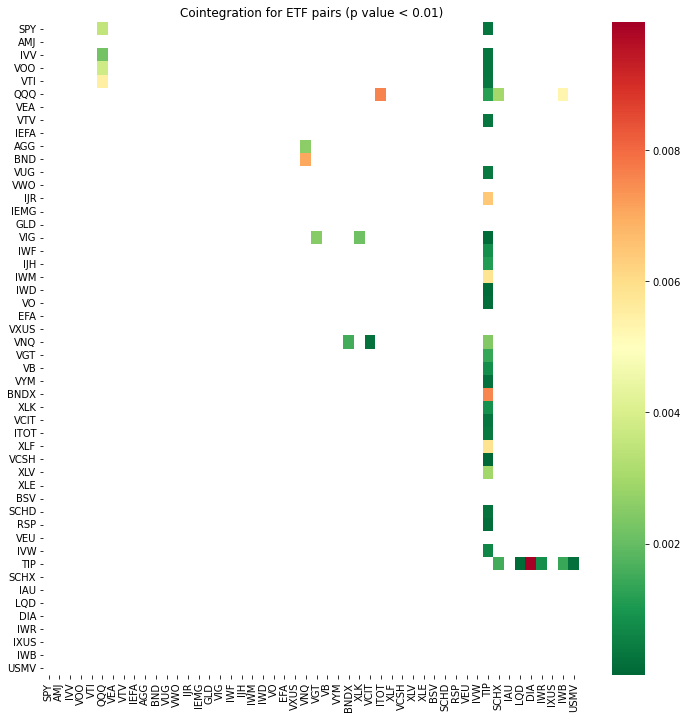

In [8]:
# In[]
# Heatmap to show the p-values of the cointegration test between each pair of
# stocks. Only show the value in the upper-diagonal of the heatmap
fig, ax = plt.subplots(figsize=(12,12))
seaborn.heatmap(pvalues, xticklabels=tickers, yticklabels=tickers, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.01)
                )
ax.set_title('Cointegration for ETF pairs (p value < 0.01)')
print(pairs) 

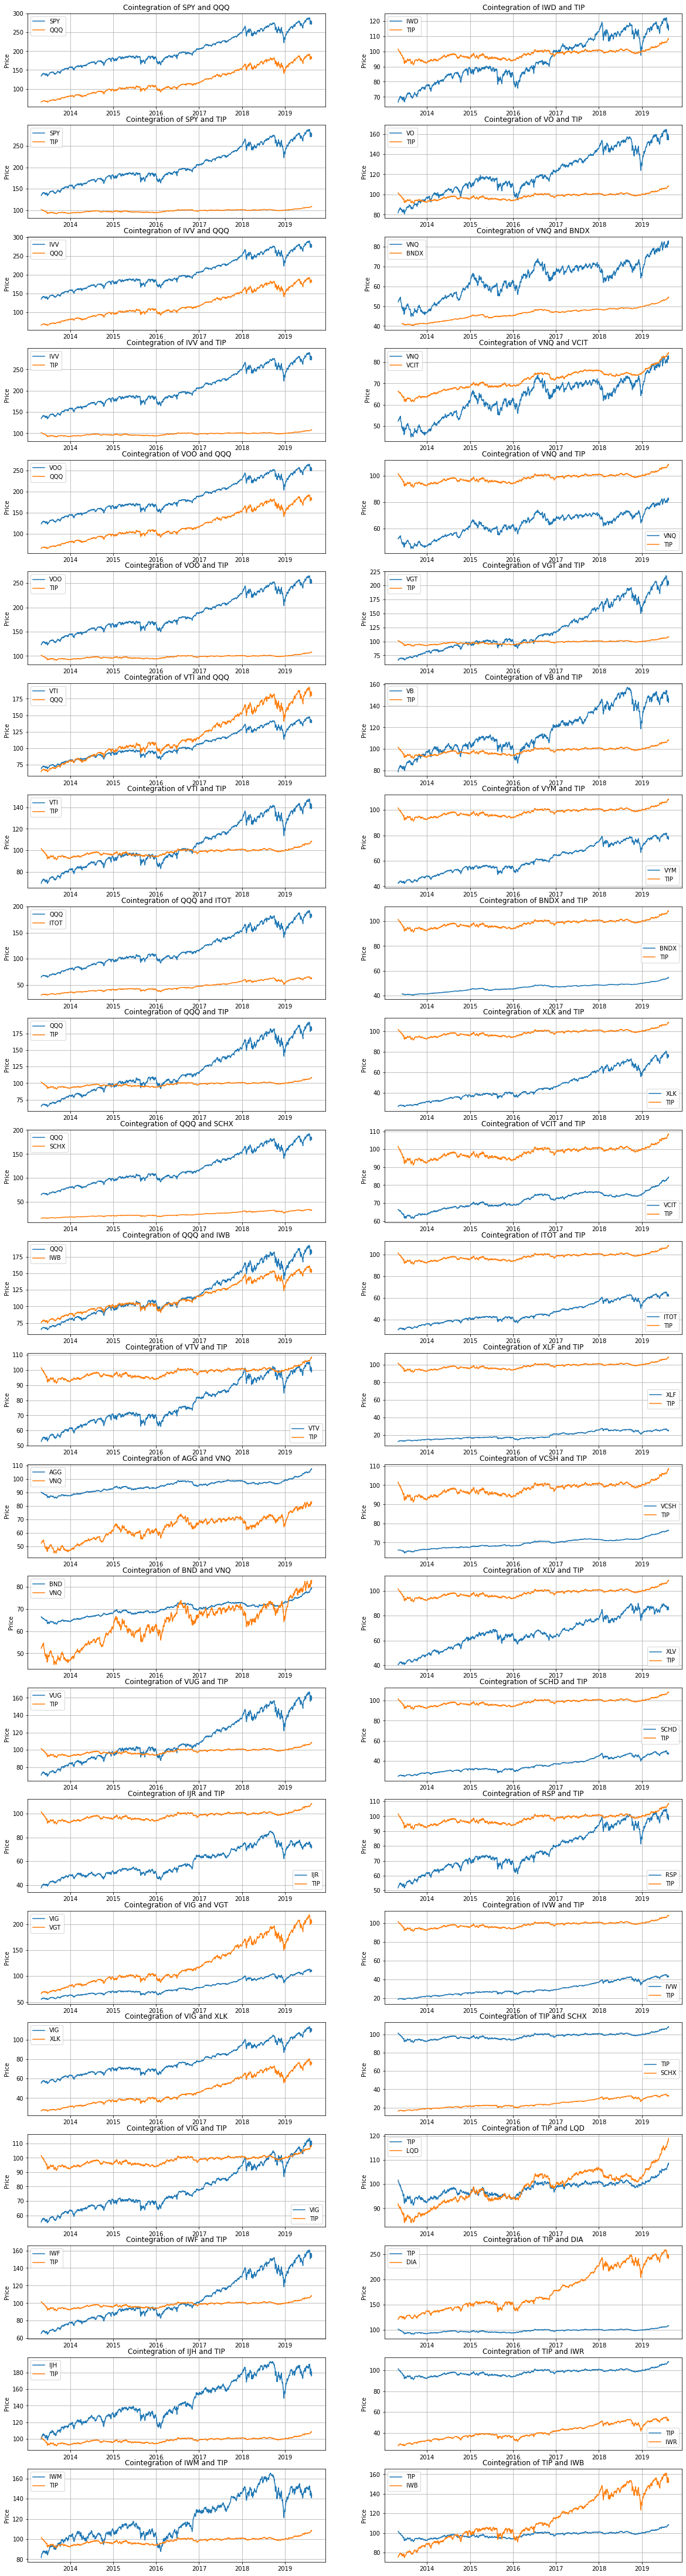

In [10]:
# In[]
#plot
#choose pairs
fig,ax = plt.subplots(int(len(pairs)/2),2,figsize = (20,80))
for i in range(int(len(pairs)/2)):
    ax[i,0].plot(train_etfs[pairs[i][0]],label = pairs[i][0])
    ax[i,0].plot(train_etfs[pairs[i][1]],label = pairs[i][1])
    ax[i,0].set_ylabel('Price')
    ax[i,0].grid(b=None, which='major', axis='both')
    ax[i,0].legend()
    ax[i,0].set_title('Cointegration of {} and {}'.format(pairs[i][0],pairs[i][1]))
    
    ax[i,1].plot(train_etfs[pairs[i + int(len(pairs)/2)][0]],label = pairs[i + int(len(pairs)/2)][0])
    ax[i,1].plot(train_etfs[pairs[i + int(len(pairs)/2)][1]],label = pairs[i + int(len(pairs)/2)][1])
    ax[i,1].set_ylabel('Price')
    ax[i,1].grid(b=None, which='major', axis='both')
    ax[i,1].legend()
    ax[i,1].set_title('Cointegration of {} and {}'.format(pairs[i + int(len(pairs)/2)][0],pairs[i + int(len(pairs)/2)][1]))

plt.show()


In [11]:
#pairs_new = pd.Series([('VNQ','XLK'),('SPY','VOO'),('IVV','VOO'),('VNQ','USMV'), ('VXUS','IXUS')])
pairs_new = pd.Series([('SPY','QQQ'),('IVV','QQQ'),('VOO','QQQ'), ('VIG','XLK'),('VCIT','TIP')])

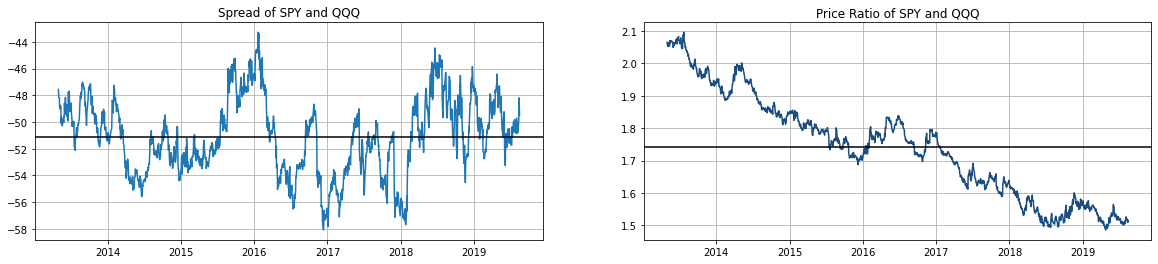

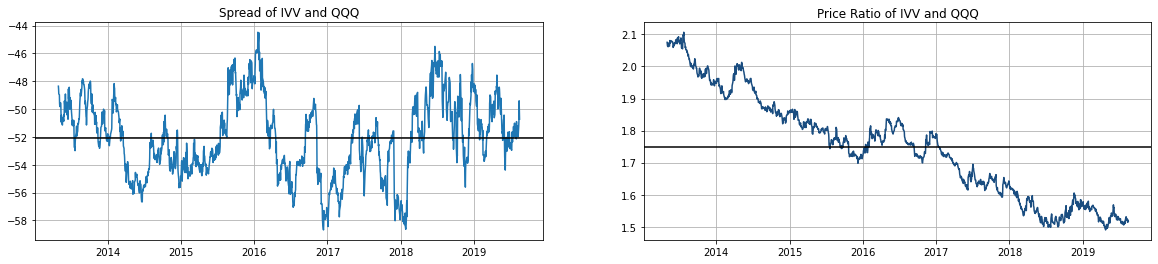

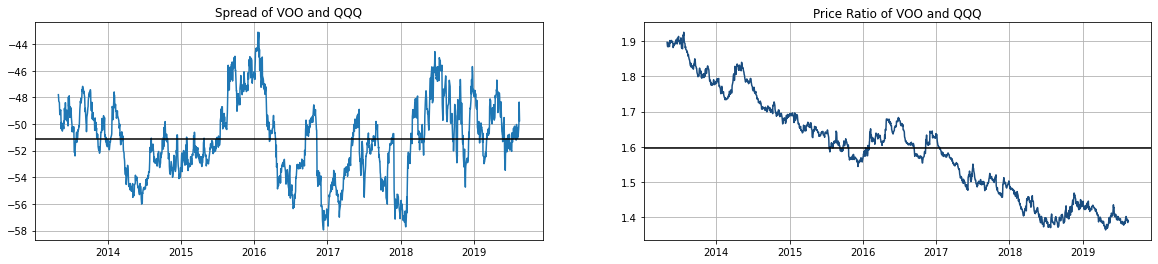

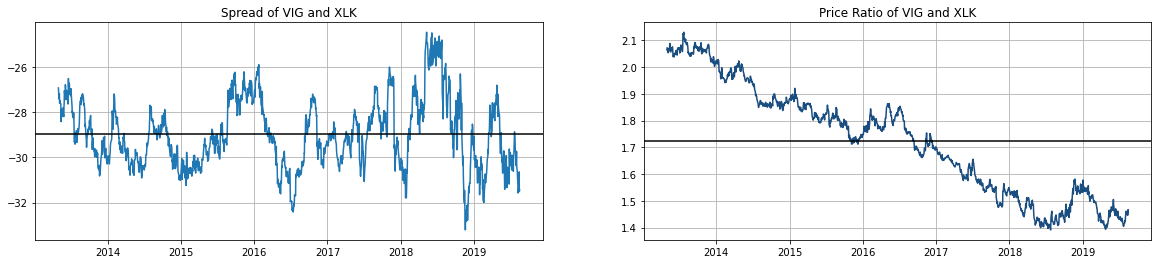

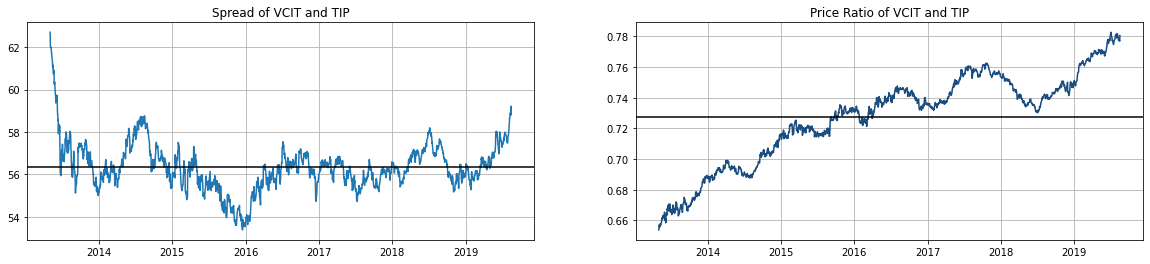

In [12]:
# In[]
#calculate spread, ratio, zscore
def calculate_features(symbol1,symbol2):
    s1 = train_etfs[symbol1]
    s2 = train_etfs[symbol2]
    
    fig,ax = plt.subplots(1,2,figsize=(20,4))
    
    #Calculating the Spread
    s1 = sm.add_constant(s1)
    results = sm.OLS(s2, s1).fit()
    s1 = s1[symbol1]
    b = results.params[symbol1]
    
    spread = s2 - b * s1
    ax[0].plot(spread)
    ax[0].axhline(spread.mean(), color='black')
    ax[0].grid(b=None, which='major', axis='both')
    ax[0].title.set_text('Spread of {} and {}'.format(symbol1,symbol2));
    
    #ratio
    ratio = s1/s2
    ax[1].plot(ratio,color = (0.1, 0.3, 0.5))
    ax[1].axhline(ratio.mean(), color='black')
    ax[1].grid(b=None, which='major', axis='both')
    ax[1].title.set_text('Price Ratio of {} and {}'.format(symbol1, symbol2));
    


for symbol1, symbol2 in pairs_new:
    calculate_features(symbol1,symbol2)


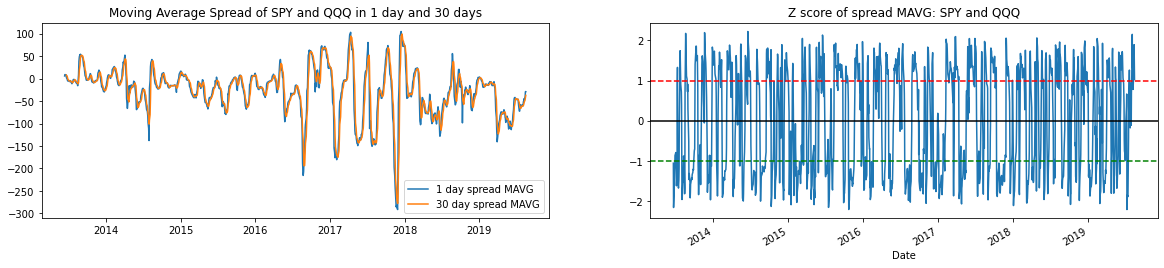

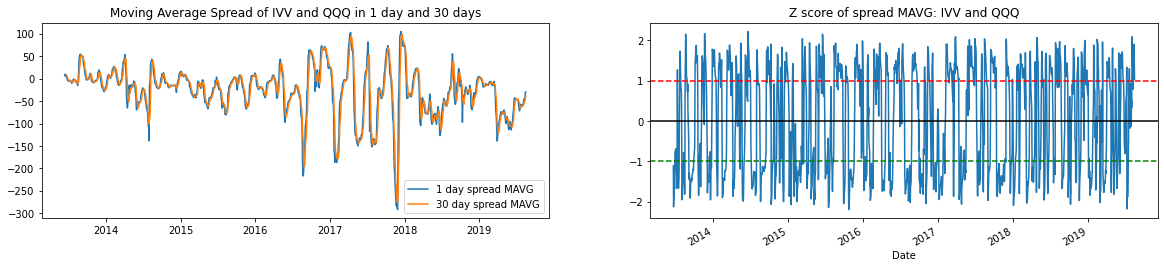

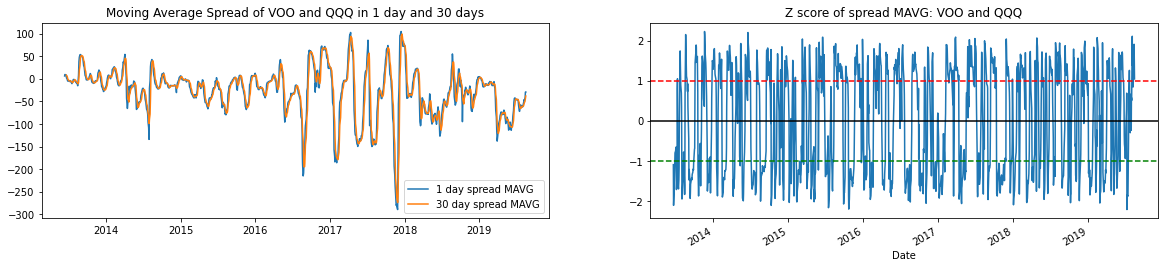

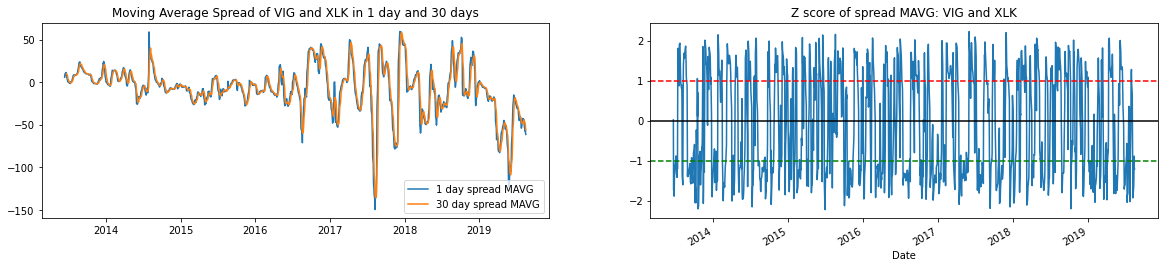

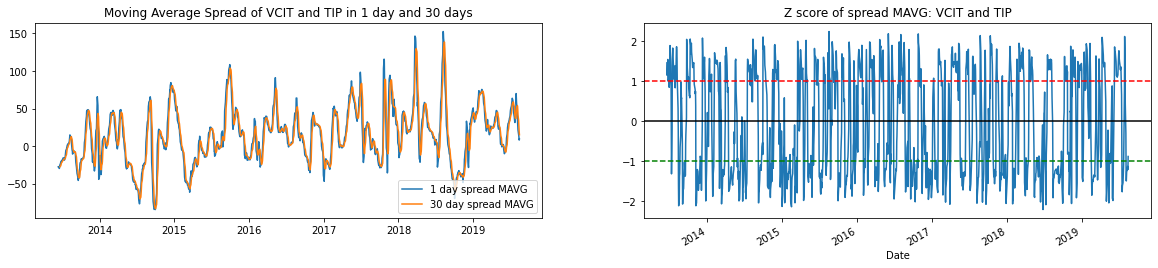

In [18]:
# In[]
#rolling windows
# 一套标准来衡量整个历史不是一个好策略。如果市场或社会产生了变化，X和Y组成的这个spread的基准线可能会产生变化，如果我们根据过去三年的数据算出了一个基准线，那么，很有可能它并不能很完美地表达此刻地世界。因此，我们的优化就是只关注一个不断滚动的窗口，每次都计算这个窗口内的基准线（平均值），我们称之为Moving Averages

#spread: rolling moving average
def calculate_spread_rolling_ma(symbol1,symbol2):
    s1 = train_etfs[symbol1]
    s2 = train_etfs[symbol2]
    
    #滚动平均值需要一个滚动的OLS来计算每一次
    rolling_beta=PandasRollingOLS(y=s2,x=s1,window=30)
    #print(rolling_beta.beta.head())

    
    #moving average
    #然后用滚动的OLS去计算滚动的平均值
    spread=s2-rolling_beta.beta['feature1']*s1
    spread.name='spread'
    
    #画出每一天的
    spread_mavg1=spread.rolling(window=1).mean()
    spread_mavg1.name='spread 1d mavg'
    #画出每30天的
    spread_mavg30=spread.rolling(window=7).mean()
    spread_mavg30.name='spread 30d mavg'
    
    #z score
    std_30=spread.rolling(window=7).std()
    std_30.name='std 30d'
    
    zscore_30_1=(spread_mavg1-spread_mavg30)/std_30
    zscore_30_1.name='z-score'
    
    return symbol1,symbol2,spread_mavg1, spread_mavg30,zscore_30_1,spread

def plot_spread_rolling_ma(symbol1,symbol2,spread_mavg1,spread_mavg30,zscore_30_1):

    fig,ax = plt.subplots(1,2,figsize=(20,4))
    ax[0].plot(spread_mavg1.index,spread_mavg1.values)
    ax[0].plot(spread_mavg30.index,spread_mavg30.values)
    ax[0].legend(['1 day spread MAVG','30 day spread MAVG'],loc = 'lower right')
    ax[0].title.set_text('Moving Average Spread of {} and {} in 1 day and 30 days'.format(symbol1,symbol2))


    #z score
    zscore_30_1.plot()
    ax[1].axhline(0,color='black')
    ax[1].axhline(1.0,color='red',linestyle='--')
    ax[1].axhline(-1.0,color='green',linestyle='--')
    ax[1].title.set_text('Z score of spread MAVG: {} and {}'.format(symbol1,symbol2))
    
    plt.show()
    


for symbol1, symbol2 in pairs_new:
    plot_spread_rolling_ma(calculate_spread_rolling_ma(symbol1,symbol2)[0],calculate_spread_rolling_ma(symbol1,symbol2)[1],calculate_spread_rolling_ma(symbol1,symbol2)[2],calculate_spread_rolling_ma(symbol1,symbol2)[3],calculate_spread_rolling_ma(symbol1,symbol2)[4])


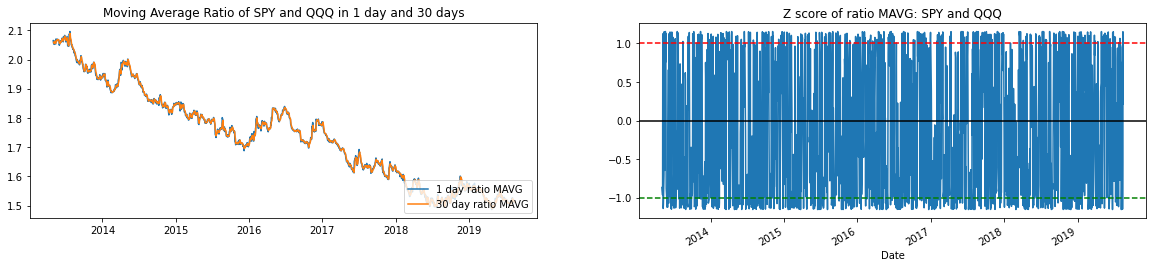

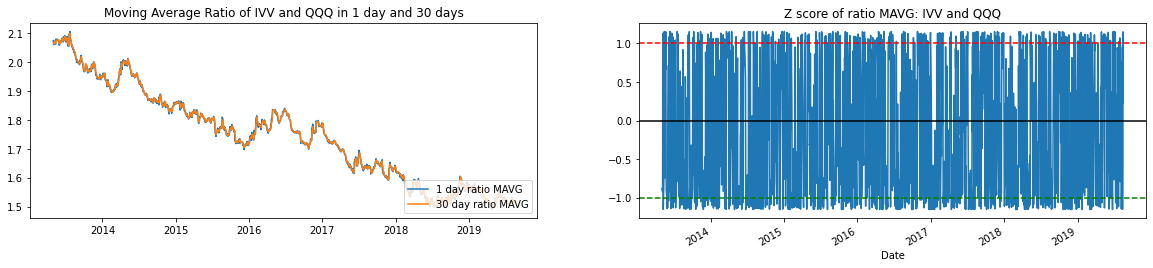

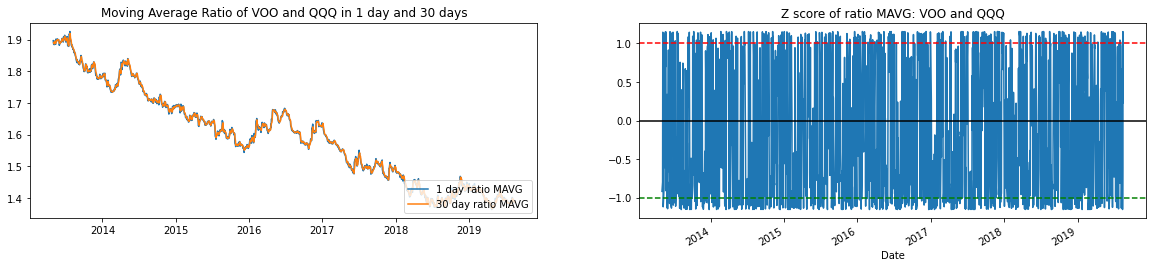

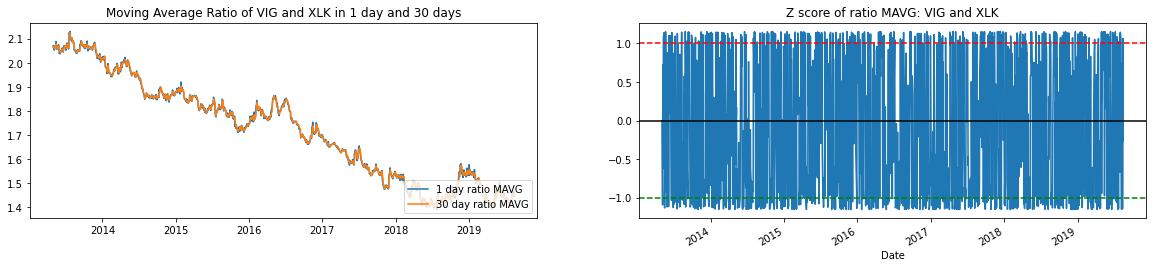

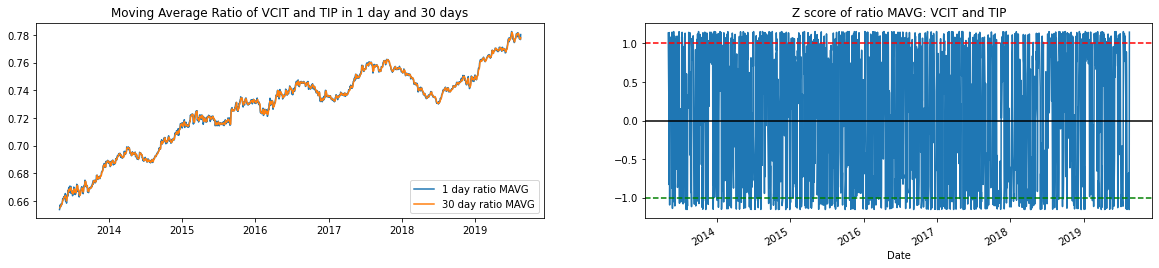

In [17]:
# In[]
#ratio: rolling moving average
def calculate_ratio_rolling_ma(symbol1,symbol2):
    s1 = train_etfs[symbol1]
    s2 = train_etfs[symbol2]
    
    #滚动平均值需要一个滚动的OLS来计算每一次
    rolling_beta=PandasRollingOLS(y=s2,x=s1,window=30)
    #print(rolling_beta.beta.head())
    

    #moving average
    ratio = s1 / s2 
    #画出每一天的
    ratio_mavg1=ratio.rolling(window=1).mean()
    ratio_mavg1.name='ratio 1d mavg'
    #画出每30天的
    ratio_mavg30=ratio.rolling(window=3).mean()
    ratio_mavg30.name='ratio 30d mavg'

    #z score
    std_30=ratio.rolling(window=3).std()
    std_30.name='std 30d'
    
    zscore_30_1=(ratio_mavg1-ratio_mavg30)/std_30
    zscore_30_1.name='z-score'
    
    #return
    return symbol1,symbol2,ratio_mavg1,ratio_mavg30,zscore_30_1,ratio


def plot_ratio_rolling_ma(symbol1,symbol2,ratio_mavg1,ratio_mavg30,zscore_30_1):
    
    fig,ax = plt.subplots(1,2,figsize=(20,4))
    
    ax[0].plot(ratio_mavg1.index,ratio_mavg1.values)
    ax[0].plot(ratio_mavg30.index,ratio_mavg30.values)
    ax[0].legend(['1 day ratio MAVG','30 day ratio MAVG'],loc = 'lower right')
    ax[0].title.set_text('Moving Average Ratio of {} and {} in 1 day and 30 days'.format(symbol1,symbol2))

    
    zscore_30_1.plot()
    ax[1].axhline(0,color='black')
    ax[1].axhline(1.0,color='red',linestyle='--')
    ax[1].axhline(-1.0,color='green',linestyle='--')
    ax[1].title.set_text('Z score of ratio MAVG: {} and {}'.format(symbol1,symbol2))
    
    plt.show()
    


for symbol1, symbol2 in pairs_new:
    plot_ratio_rolling_ma(calculate_ratio_rolling_ma(symbol1,symbol2)[0],calculate_ratio_rolling_ma(symbol1,symbol2)[1],calculate_ratio_rolling_ma(symbol1,symbol2)[2],calculate_ratio_rolling_ma(symbol1,symbol2)[3],calculate_ratio_rolling_ma(symbol1,symbol2)[4])


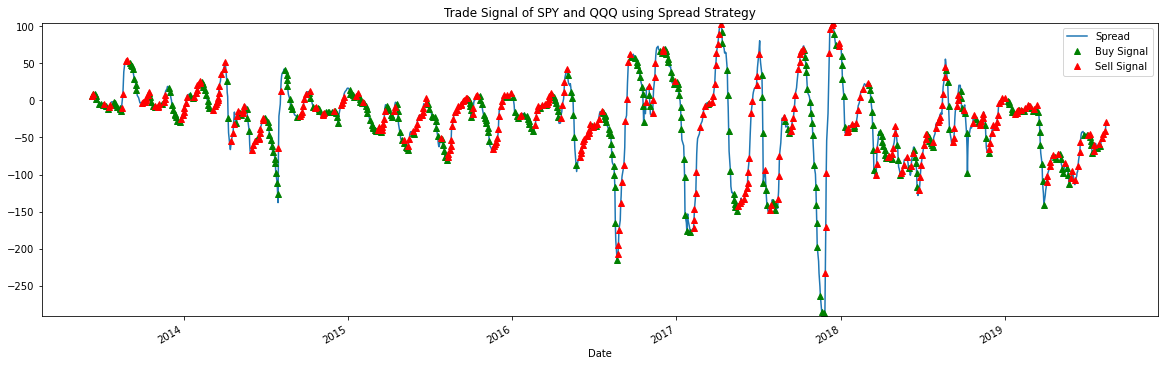

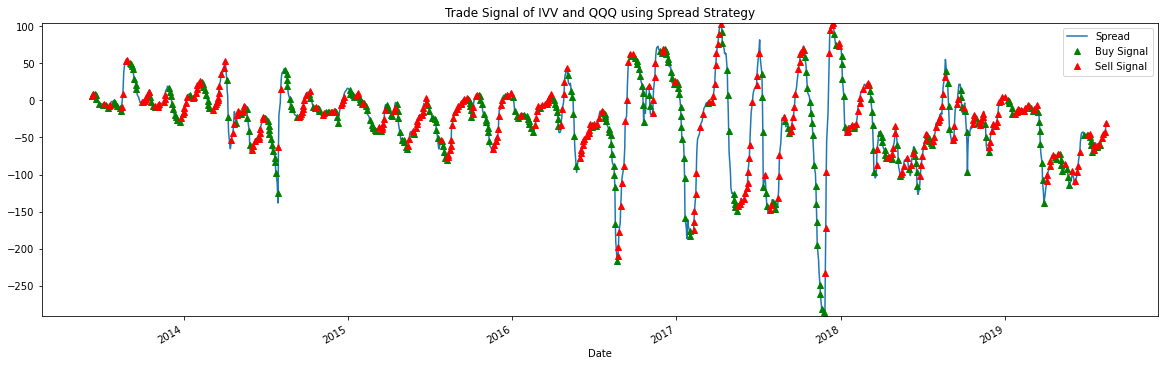

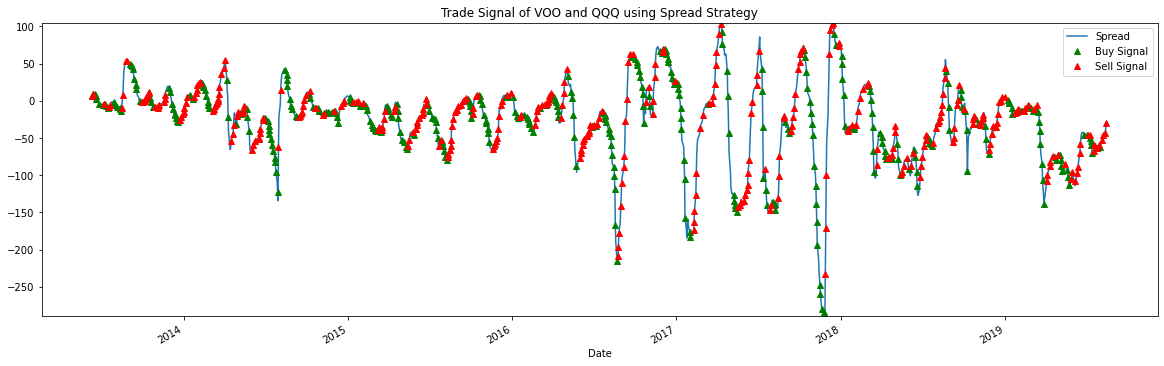

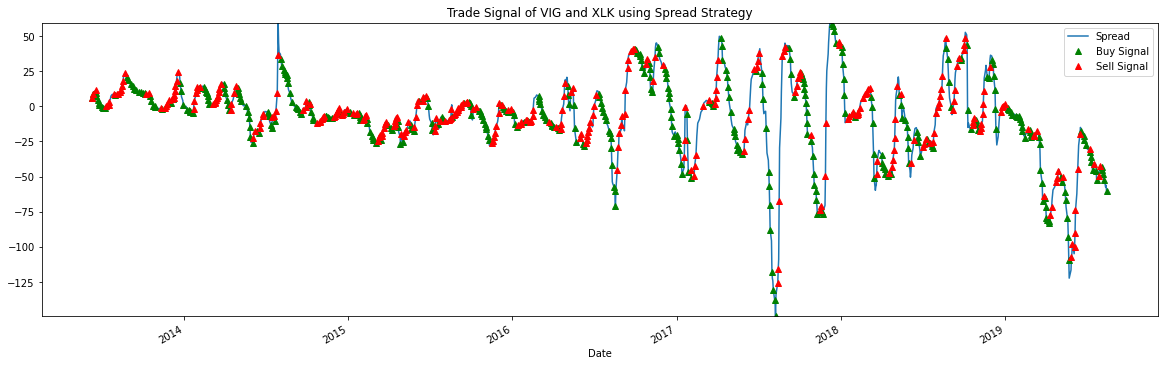

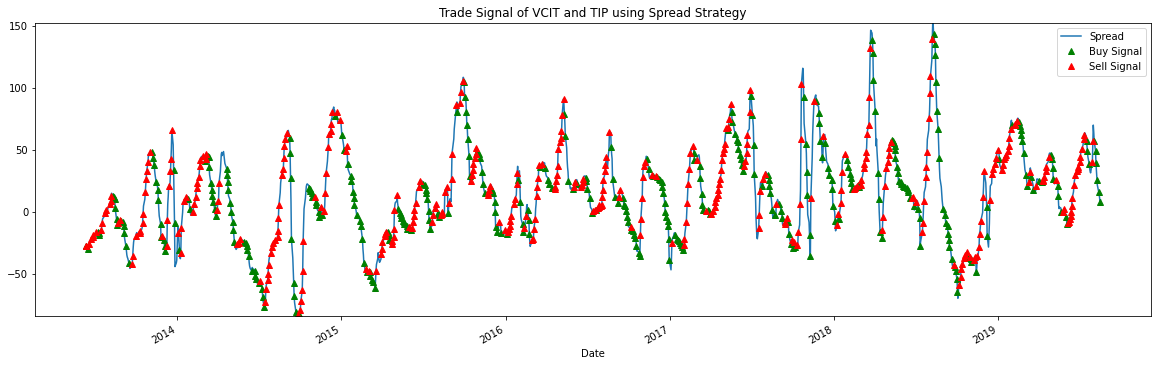

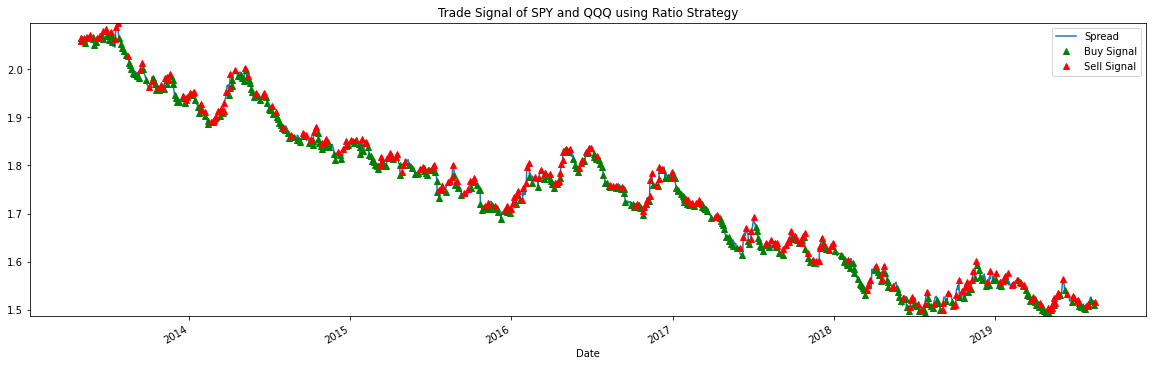

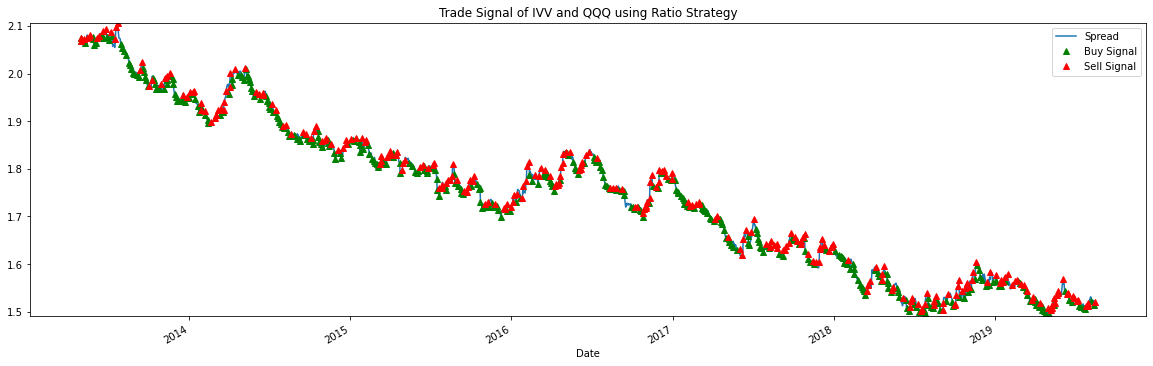

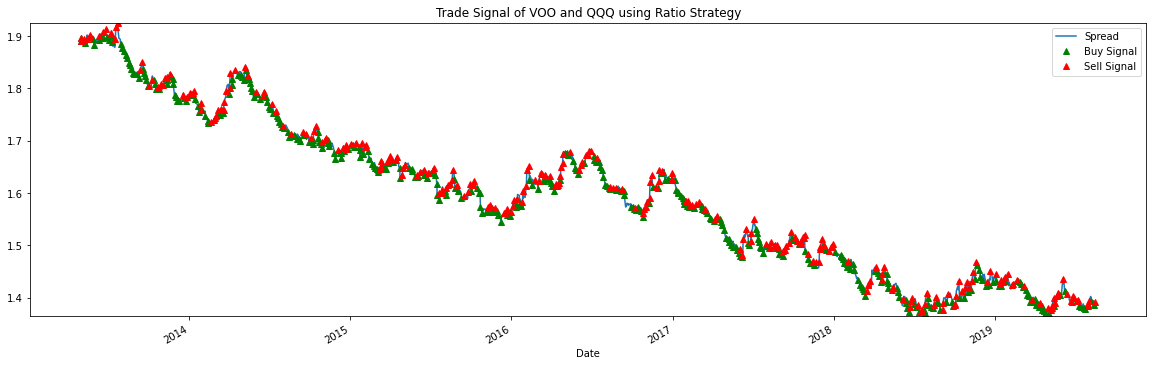

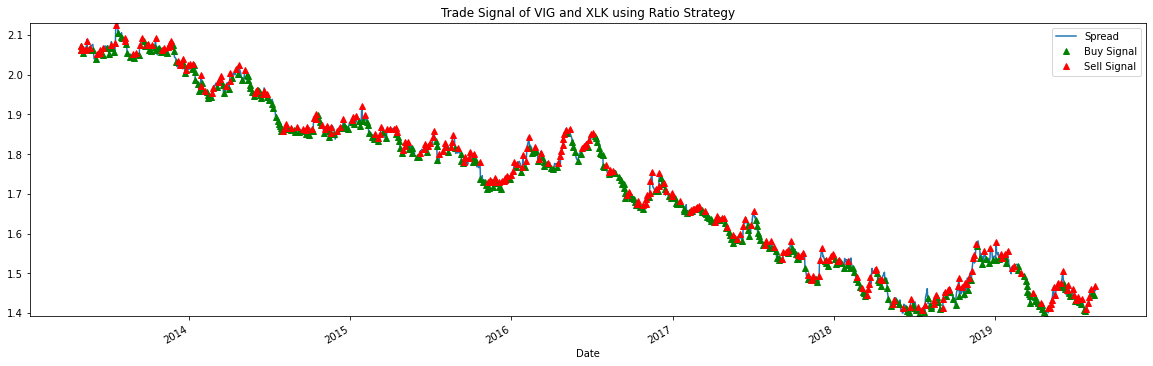

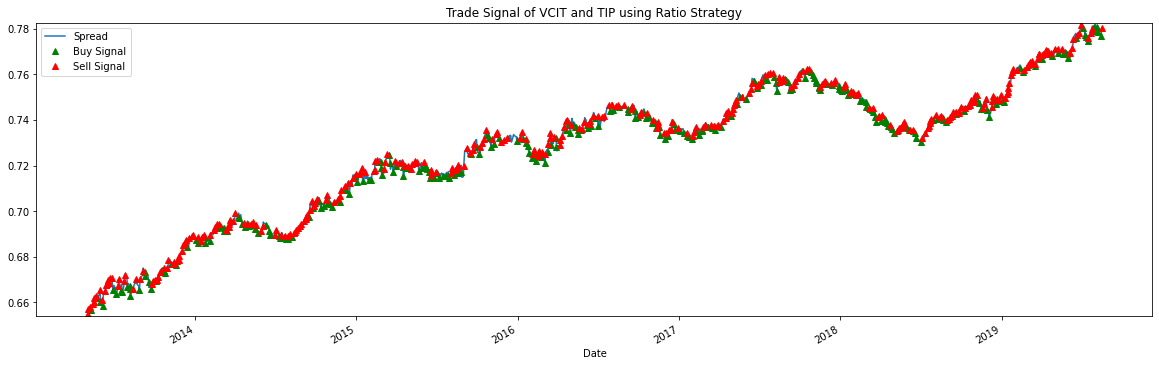

In [15]:
# In[]
#trade signal
def plot_trade_signal(symbol1,symbol2,signal,zscore_30_1,strategy):
    #signal    
    plt.figure(figsize=(20,6))
    
    signal.plot()
    buy = signal.copy()
    sell = signal.copy()
    buy[zscore_30_1>-1] = np.nan
    sell[zscore_30_1<1] = np.nan
    
    #buy = pd.Series(filter(lambda val: val !=  0, buy))

    plt.plot(buy,color='g', linestyle='None', marker='^')
    plt.plot(sell,color='r', linestyle='None', marker='^')
    x1, x2, y1, y2 = plt.axis()
    plt.axis((x1, x2, signal.min(), signal.max()))

    plt.legend(['Spread', 'Buy Signal', 'Sell Signal'])
    plt.title('Trade Signal of {} and {} using {}'.format(symbol1,symbol2,strategy))
    plt.show()
    

#spread
for symbol1, symbol2 in pairs_new:
    plot_trade_signal(calculate_spread_rolling_ma(symbol1,symbol2)[0],calculate_spread_rolling_ma(symbol1,symbol2)[1],calculate_spread_rolling_ma(symbol1,symbol2)[5],calculate_spread_rolling_ma(symbol1,symbol2)[4],'Spread Strategy')  

    
#ratio
for symbol1, symbol2 in pairs_new:
    plot_trade_signal(calculate_ratio_rolling_ma(symbol1,symbol2)[0],calculate_ratio_rolling_ma(symbol1,symbol2)[1],calculate_ratio_rolling_ma(symbol1,symbol2)[5],calculate_ratio_rolling_ma(symbol1,symbol2)[4],'Ratio Strategy')  



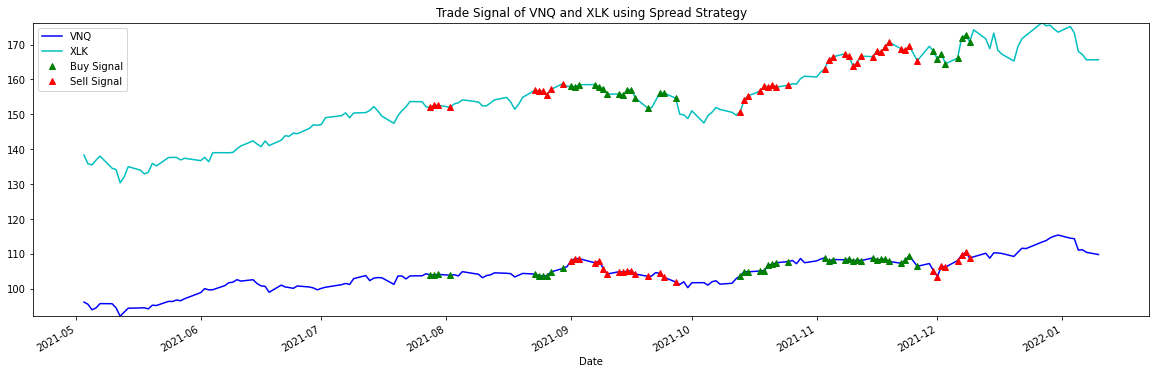

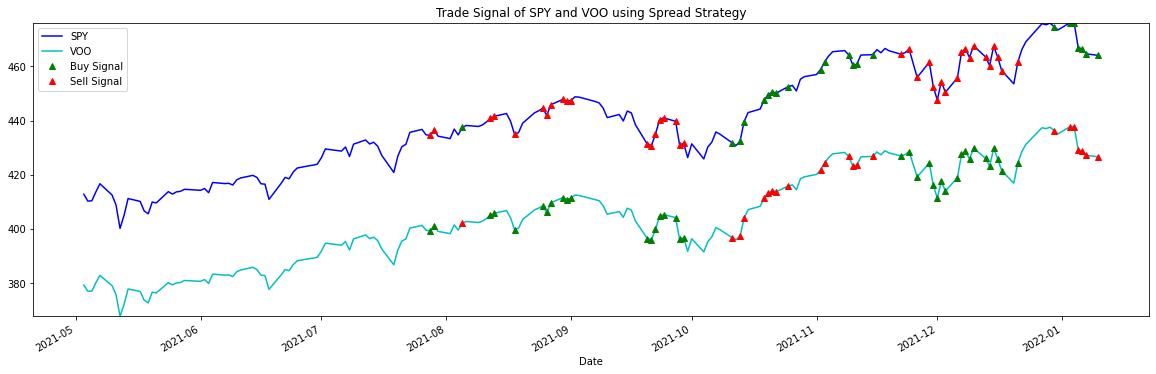

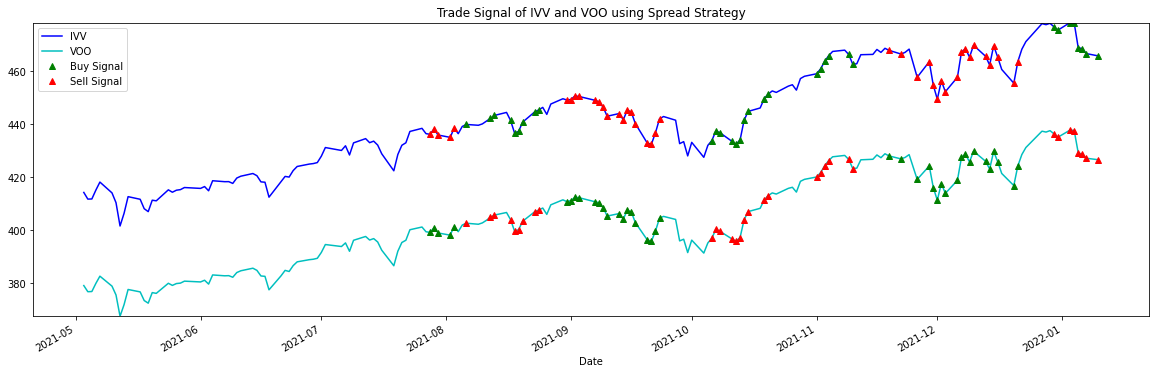

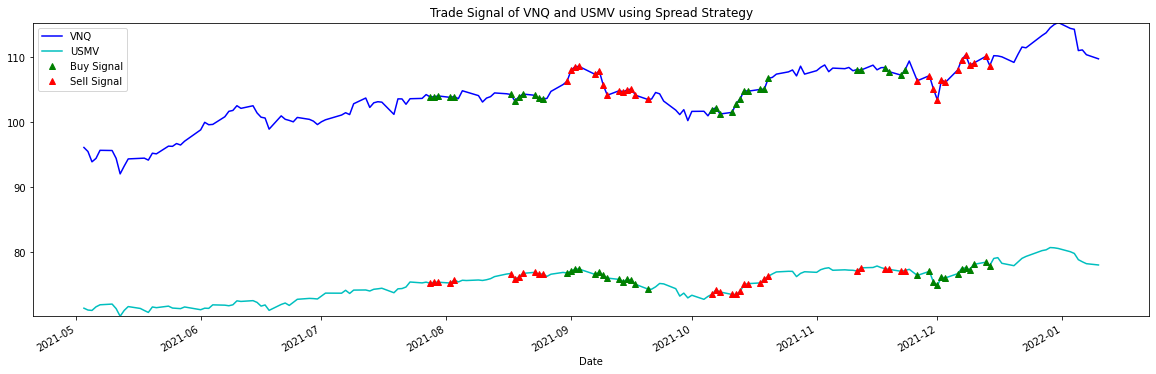

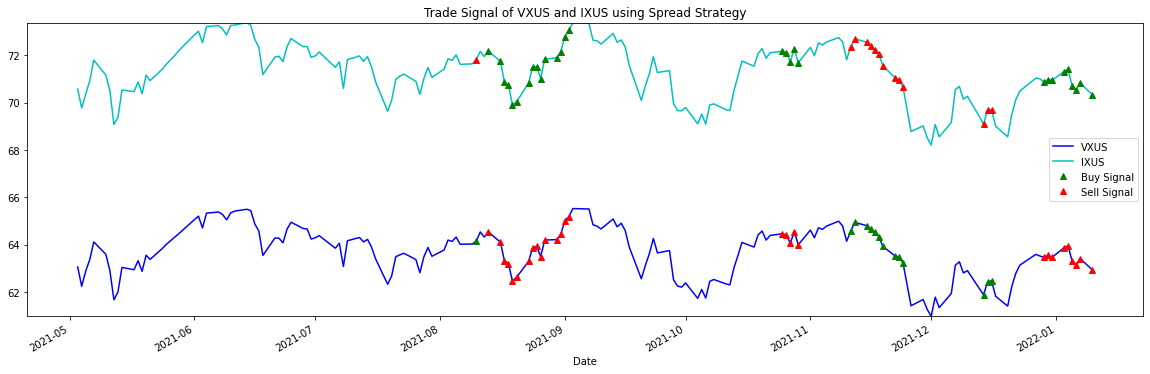

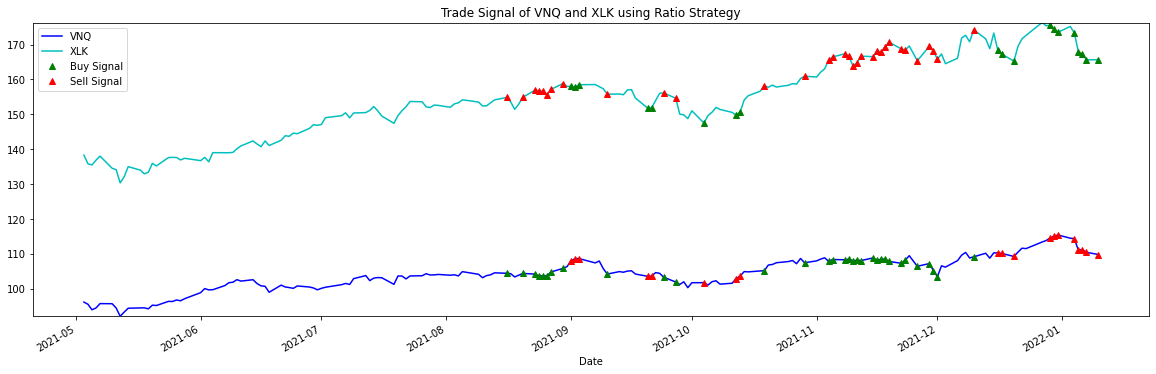

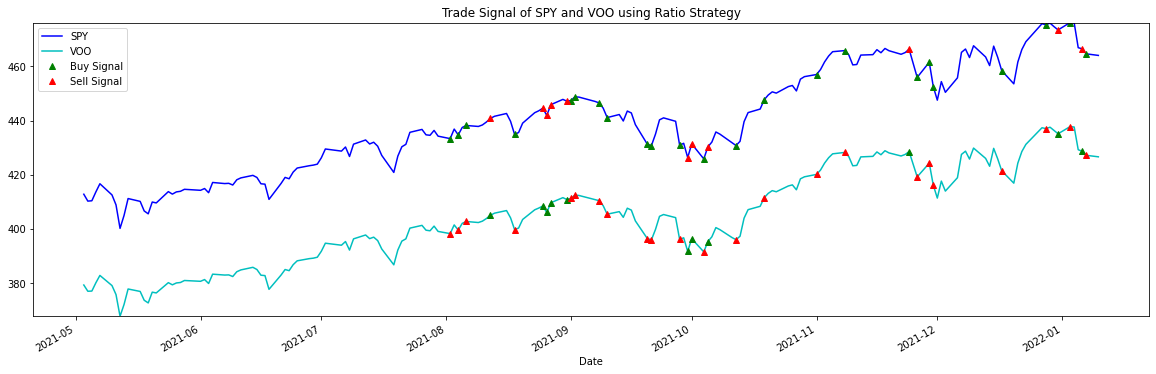

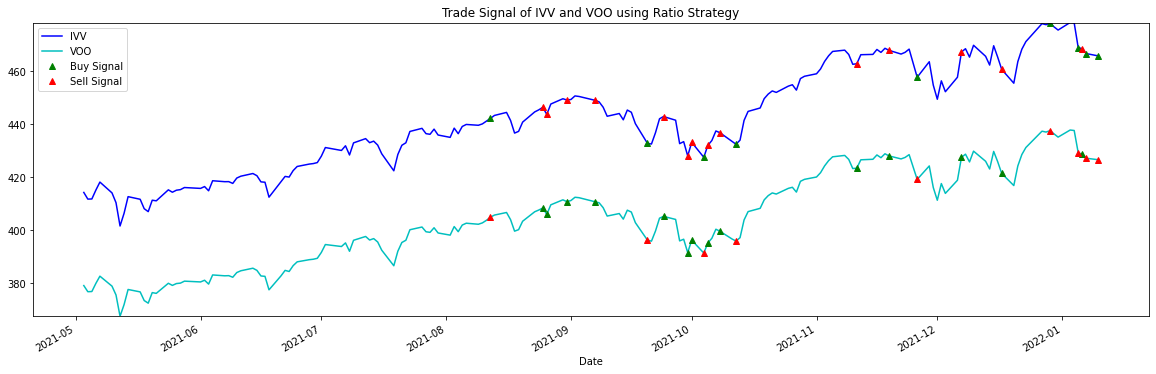

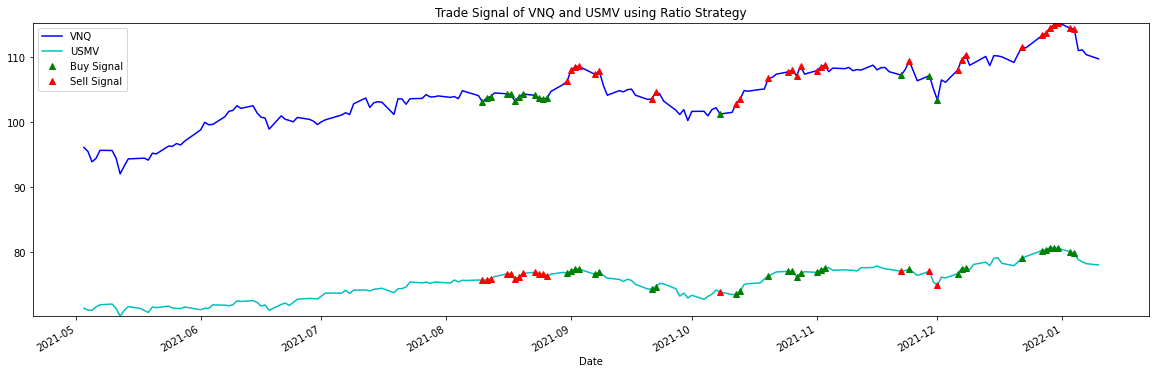

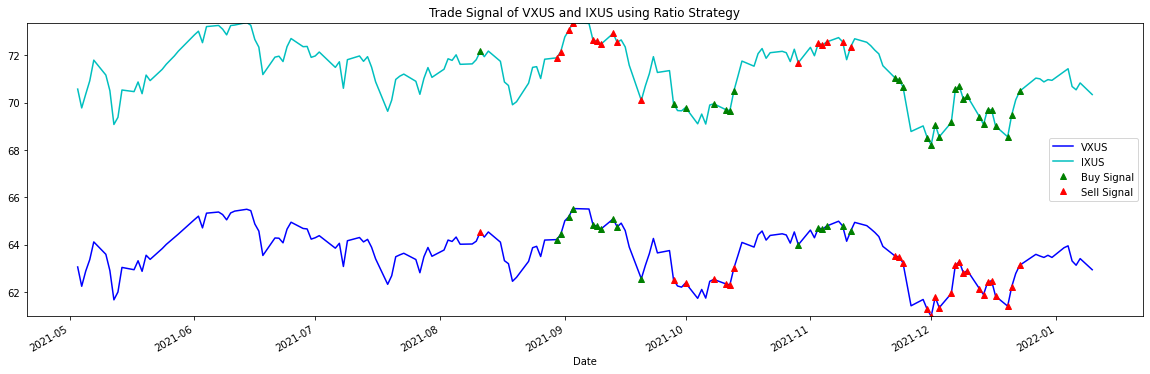

In [433]:
# In[]
def plot_stock_signal(symbol1,symbol2,signal,zscore_30_1,strategy):
    
    plt.figure(figsize=(20,6))
    
    #signal
    buy = signal.copy()
    sell = signal.copy()
    buy[zscore_30_1>-1] = 0
    sell[zscore_30_1<1] = 0
    
    # stock price
    S1 = train_etfs[symbol1]
    S2 = train_etfs[symbol2]
    
    S1.plot(color='b')
    S2.plot(color='c')
    buyR = 0*S1.copy()
    sellR = 0*S1.copy()
    
    # When you buy the ratio, you buy stock S1 and sell S2
    buyR[buy!=0] = S1[buy!=0]
    sellR[buy!=0] = S2[buy!=0]
    
    # When you sell the ratio, you sell stock S1 and buy S2
    buyR[sell!=0] = S2[sell!=0]
    sellR[sell!=0] = S1[sell!=0]
    
    buyR[60:].plot(color='g', linestyle='None', marker='^')
    sellR[60:].plot(color='r', linestyle='None', marker='^')
    x1, x2, y1, y2 = plt.axis()
    plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
    
    plt.legend([symbol1, symbol2, 'Buy Signal', 'Sell Signal'])
    plt.title('Trade Signal of {} and {} using {}'.format(symbol1,symbol2,strategy))
    plt.show()
    

#spread
for symbol1, symbol2 in pairs_new:
    plot_stock_signal(calculate_spread_rolling_ma(symbol1,symbol2)[0],calculate_spread_rolling_ma(symbol1,symbol2)[1],calculate_spread_rolling_ma(symbol1,symbol2)[5],calculate_spread_rolling_ma(symbol1,symbol2)[4],'Spread Strategy')  

#ratio
for symbol1, symbol2 in pairs_new:
    plot_stock_signal(calculate_ratio_rolling_ma(symbol1,symbol2)[0],calculate_ratio_rolling_ma(symbol1,symbol2)[1],calculate_ratio_rolling_ma(symbol1,symbol2)[5],calculate_ratio_rolling_ma(symbol1,symbol2)[4],'Ratio Strategy')  



In [262]:
# In[]
# Trade using a simple strategy
def trade_spread(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    
    rolling_beta=PandasRollingOLS(y=S2,x=S1,window=30)
    
    spread = S2-rolling_beta.beta['feature1']*S1
    
    ma1 = spread.rolling(window=window1,
                               center=False).mean()
    ma2 = spread.rolling(window=window2,
                               center=False).mean()
    
    std = spread.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = [0]
    countS1 = []
    countS2 = []
    
    
    for i in range(len(spread)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money.append(S1[i] - S2[i] * spread[i])
            countS1.append(-1)
            countS2.append(spread[i])
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money.append(S1[i] - S2[i] * spread[i])
            countS1.append(1)
            countS2.append(-spread[i])
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        #elif abs(zscore[i]) < 0.5:
            #money.append(S1[i] * countS1 + S2[i] * countS2)
            #countS1.append(0)
            #countS2.append(0)
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
        else:
            money.append(money[-1])
            countS1.append(0)
            countS2.append(0)

        
    res1 = pd.DataFrame(countS1, columns = ['position1'],index = S1.index)
    res2 = pd.DataFrame(countS2, columns = ['position2'],index = S1.index)
    res3 = pd.DataFrame(money[1:], columns = ['profit'],index = S1.index)
    
    return pd.concat([res3, res1, res2],axis = 1)


In [66]:
# In[]
def trade_ratio(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = [0]
    countS1 = []
    countS2 = []
    
    
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money.append(S1[i] - S2[i] * ratios[i])
            countS1.append(-1)
            countS2.append(ratios[i])
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money.append(S1[i] - S2[i] * ratios[i])
            countS1.append(1)
            countS2.append(-ratios[i])
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        else:
            money.append(money[-1])
            countS1.append(0)
            countS2.append(0)
    
    res1 = pd.DataFrame(countS1, columns = ['position1'],index = S1.index)
    res2 = pd.DataFrame(countS2, columns = ['position2'],index = S1.index)
    res3 = pd.DataFrame(money[1:], columns = ['profit'],index = S1.index)
    
    return pd.concat([res3, res1, res2],axis = 1)


In [442]:
# In[]
def returns(data,symbol1,symbol2):
    data['returns_1'] = np.log(etfs[symbol1]/etfs[symbol1].shift(1))
    data['returns_2'] = np.log(etfs[symbol2]/etfs[symbol2].shift(1))
    data['returns_strategy' ] = 0.5*(data['returns_1']* data['position1'].shift(1)) + 0.5* (data['returns_2']* data['position2'].shift(1))
    
    return data

returns_spread_train = []
returns_ratio_train = []
for symbol1, symbol2 in pairs_new:
    returns_spread_train.append(returns(trade_spread(train_etfs[symbol1], train_etfs[symbol2], 1, 30),symbol1,symbol2)['returns_strategy'])
    returns_ratio_train.append(returns(trade_ratio(train_etfs[symbol1], train_etfs[symbol2], 1, 30),symbol1,symbol2)['returns_strategy'])
  

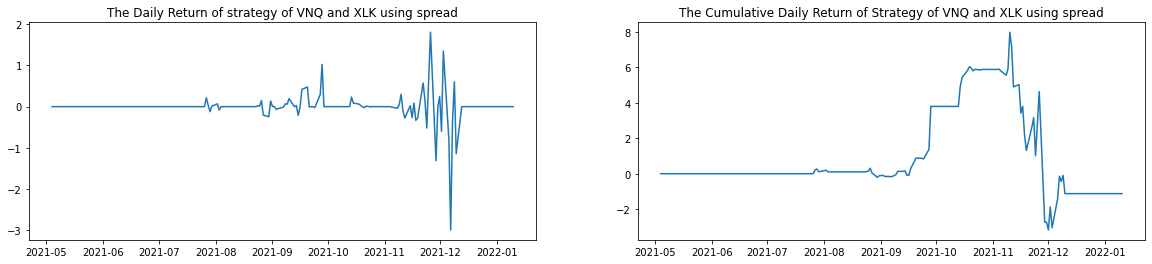

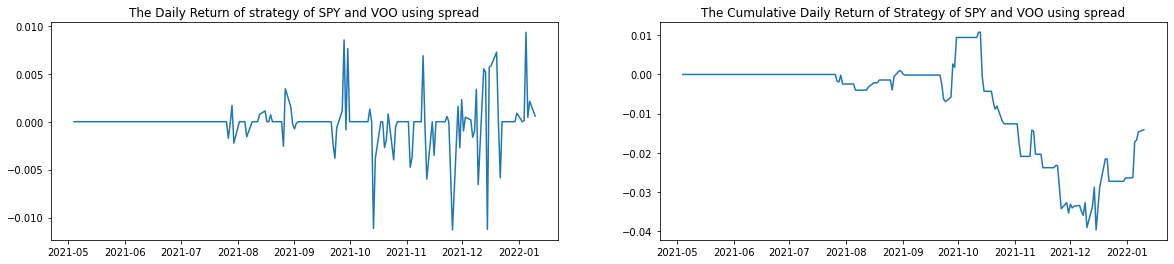

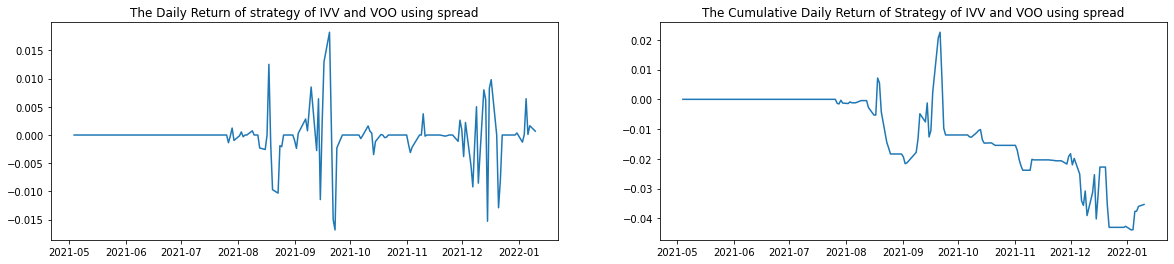

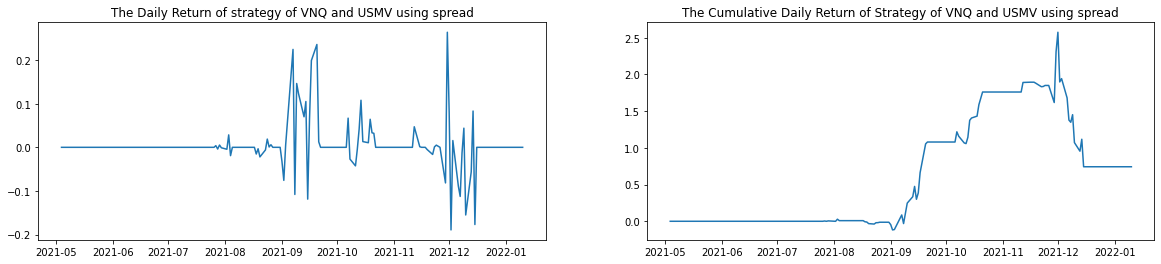

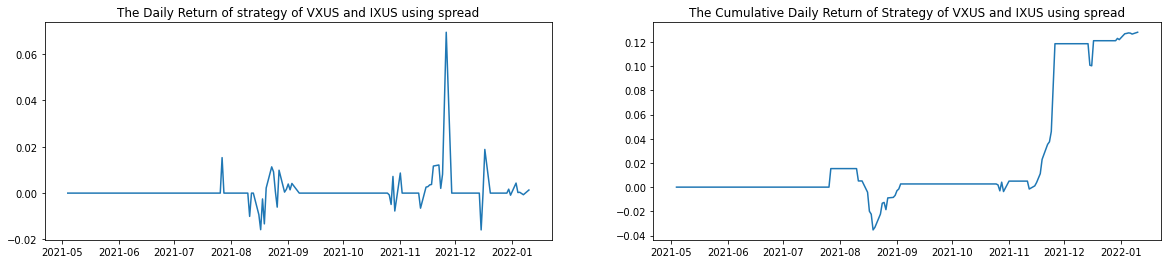

In [443]:
#plots returns and cumulative returns using spread
for i in range(len(returns_spread_train)):
    fig,ax = plt.subplots(1,2,figsize = (20,4))
    ax[0].plot(returns_spread_train[i])
    ax[0].set_title('The Daily Return of strategy of {} and {} using spread'.format(pairs_new[i][0],pairs_new[i][1]))
    ax[1].plot((1+returns_spread_train[i]).cumprod()-1)
    ax[1].set_title('The Cumulative Daily Return of Strategy of {} and {} using spread'.format(pairs_new[i][0],pairs_new[i][1]))
    

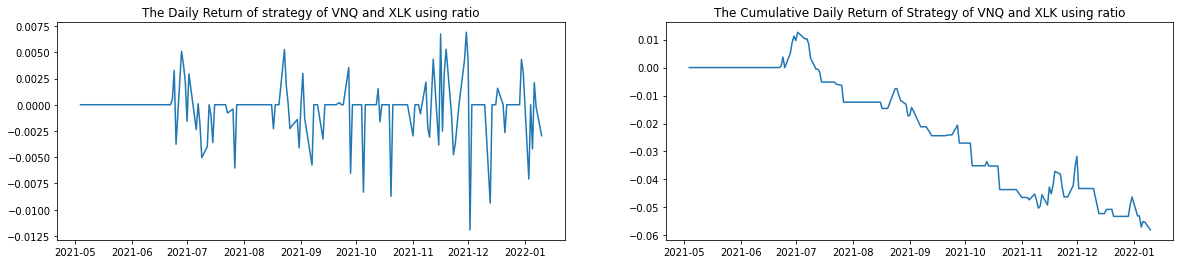

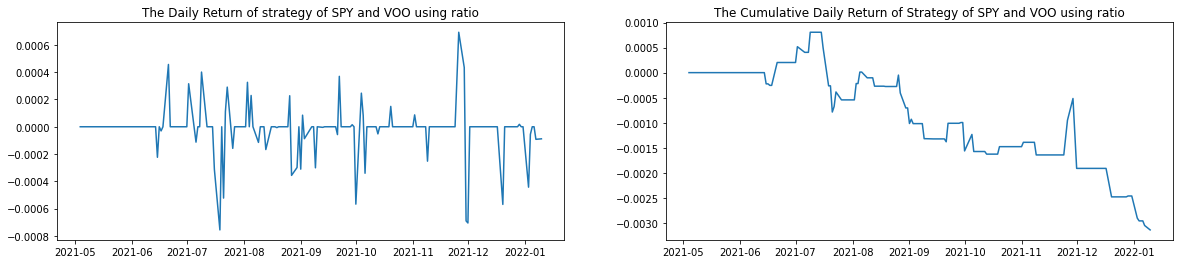

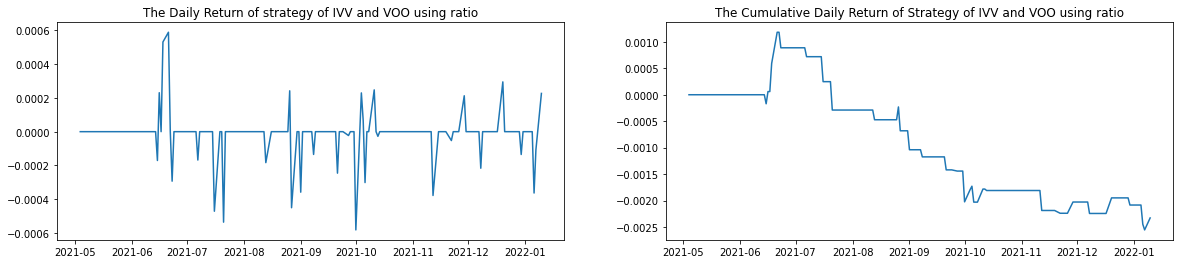

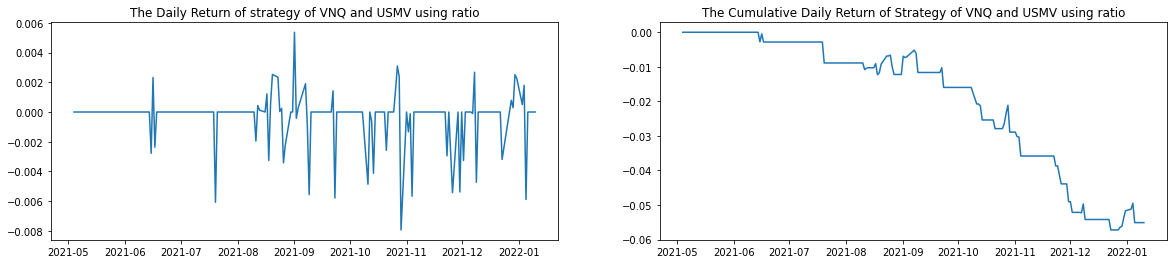

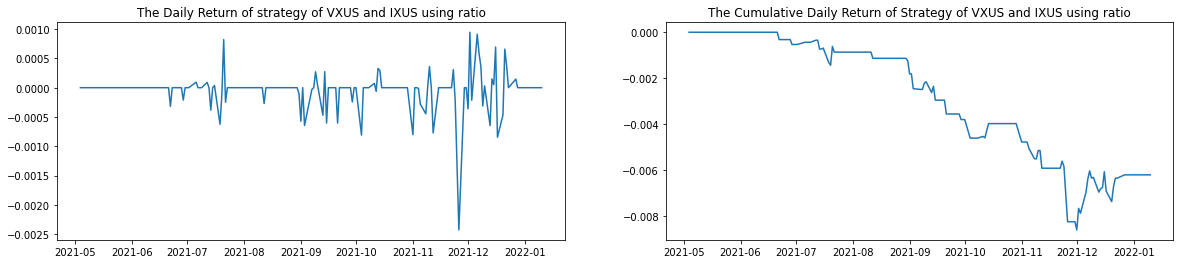

In [444]:
#plots returns and cumulative returns using ratio
for i in range(len(returns_ratio_train)):
    fig,ax = plt.subplots(1,2,figsize = (20,4))
    ax[0].plot(returns_ratio_train[i])
    ax[0].set_title('The Daily Return of strategy of {} and {} using ratio'.format(pairs_new[i][0],pairs_new[i][1]))
    ax[1].plot((1+returns_ratio_train[i]).cumprod()-1)
    ax[1].set_title('The Cumulative Daily Return of Strategy of {} and {} using ratio'.format(pairs_new[i][0],pairs_new[i][1]))
    

In [482]:
returns_spread_all = []
returns_ratio_all = []
for symbol1, symbol2 in pairs_new:
    returns_spread_all.append(returns(trade_spread(etfs[symbol1], etfs[symbol2], 1, 30),symbol1,symbol2)['returns_strategy'])
    returns_ratio_all.append(returns(trade_ratio(etfs[symbol1], etfs[symbol2], 1, 30),symbol1,symbol2)['returns_strategy'])
  

returns_spread_portfolio = ((returns_spread_all[2]+returns_spread_all[3]+returns_spread_all[4])/3).fillna(method = 'bfill')
returns_ratio_portfolio = ((returns_ratio_all[2]+returns_ratio_all[3]+returns_ratio_all[4])/3).fillna(method = 'bfill')


In [467]:
start_date = '2021-05-01'
end_date = '2022-05-01'

hist_spy = yf.Ticker('SPY').history(start = start_date, end = end_date,interval = "1d")['Close']
pct_change_spy = hist_spy.pct_change().fillna(0).astype('float').tz_localize('UTC')

/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


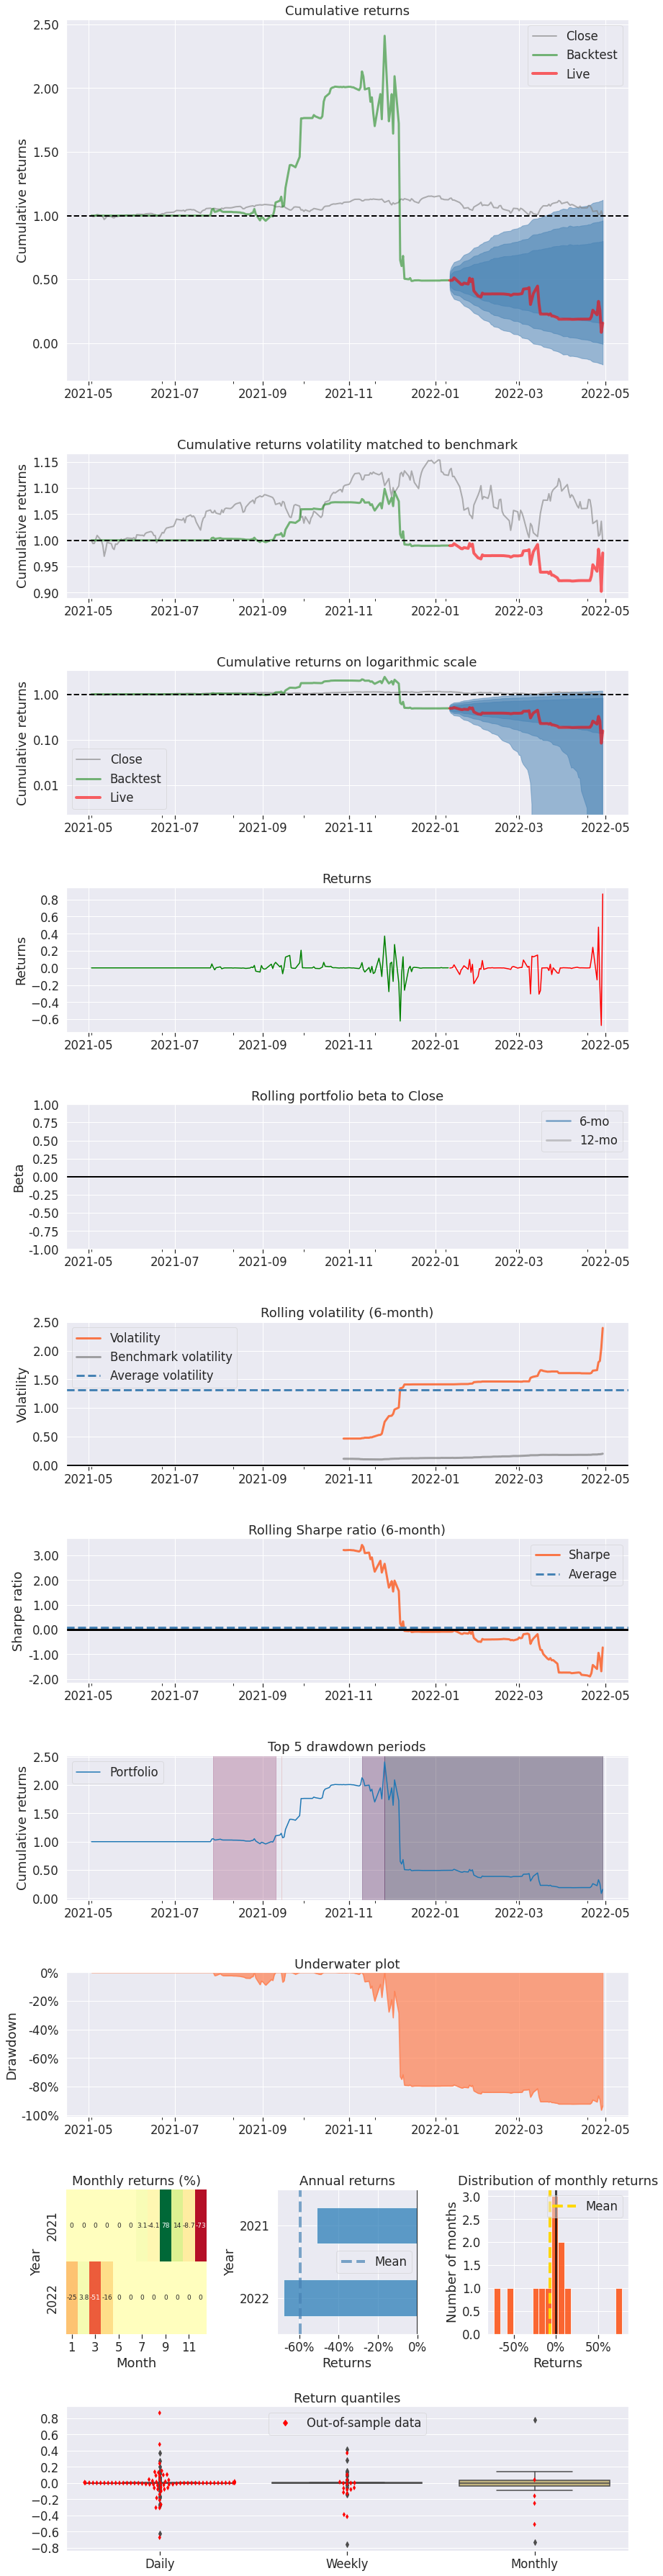

In [481]:
#spread
fig_1 = pf.create_returns_tear_sheet(returns_spread_portfolio.tz_localize('UTC'),benchmark_rets = pct_change_spy, live_start_date = etfs[split:].index[0],return_fig=True)
for ax in fig_1.axes:
        ax.tick_params(
        axis='x',           # changes apply to the x-axis
        which='both',       # both major and minor ticks are affected
        bottom=True,
        top=False,
        labelbottom=True)    # labels along the bottom edge are on
plt.savefig('Tear Sheet: pair trading spread strategy.png') 


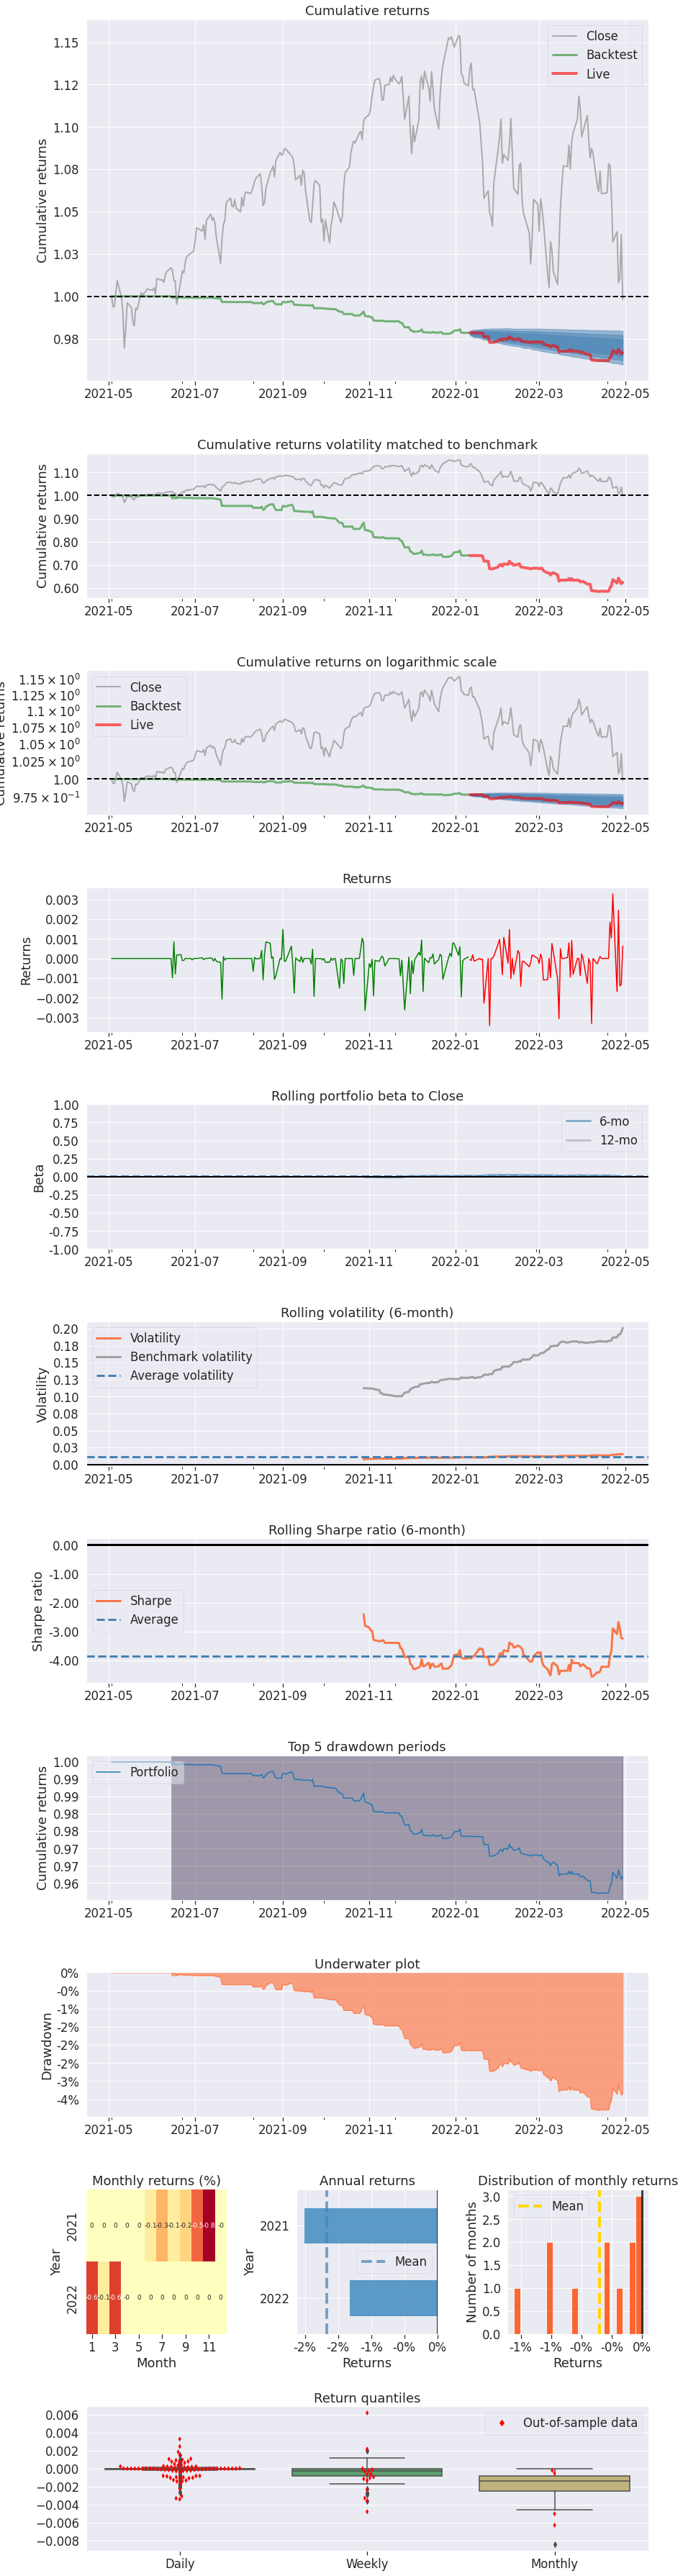

In [484]:
#ratio
fig_2 = pf.create_returns_tear_sheet(returns_ratio_portfolio.tz_localize('UTC'),benchmark_rets = pct_change_spy, live_start_date = etfs[split:].index[0],return_fig=True)
for ax in fig_2.axes:
        ax.tick_params(
        axis='x',           # changes apply to the x-axis
        which='both',       # both major and minor ticks are affected
        bottom=True,
        top=False,
        labelbottom=True)    # labels along the bottom edge are on
plt.savefig('Tear Sheet: pair trading ratio strategy.png') 